# 正規分布に従うデータでMCMC実行

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/data.xlsx")

In [4]:
df.head()

,Unnamed: 0,0
0,0,3.896195
1,1,5.865766
2,2,5.860887
3,3,4.660614
4,4,5.263595


(array([ 1.,  1.,  5., 12., 10., 18., 16.,  8.,  5.,  4.]),
 array([2.29193477, 2.77510498, 3.25827519, 3.74144541, 4.22461562,
        4.70778584, 5.19095605, 5.67412627, 6.15729648, 6.64046669,
        7.12363691]),
 <BarContainer object of 10 artists>)

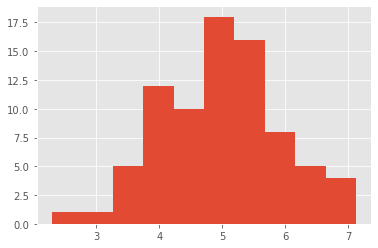

In [5]:
# ヒストグラムからデータが正規分布疎っぽいことがわかる
# 尤度を正規分布にしてモデリングしていく

plt.hist(df[0])

In [6]:
# PyStanは書き方が特殊
# コメントで以下のようなブロックを書く必要がある
# ①dataブロック（観測したデータの入れ物）→
# ②パラメータのブロック→
#  real<lower=0> sigma; は標準偏差が正の値に指定
# ③統計モデルの（尤度関数）ブロック→
#  Y[i] ~ normal(mu, sigma); は正規分布
# ④事前分布
#  省略している。事前分布していなければ無条件兼事前分布が事前分布になる

stan_model = """
data {
  int N;
  real Y[N];
}

parameters {
  real mu;
  real<lower=0> sigma;
}

model {
  for (i in 1:N){
    Y[i] ~ normal(mu, sigma);
  }
}
"""

In [7]:
# PyStanはコンパイルが必要（C++でコンパイルされる）
# 結構時間かかる

sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4abdfcd24c05f6fb8dff0fb579217c90 NOW.


In [8]:
# dataブロックに入れるデータを辞書型で渡す

stan_data = {"N":df.shape[0], "Y":df[0]}

In [9]:
# MCMCでサンプリング

fit = sm.sampling(data=stan_data,  # データ渡す
                  iter=2000,  # モンテカルロステップ（サンプリング回数）
                  chains=3,  # 指定したモンテカルロステップ（iter=2000）を何回やるか。3なら2000*3回モンテカルロステップ実行
                  warmup=500,  # ウォームアップ。この分のstepは捨てる
                  seed=123)

In [10]:
# 結果の抽出
# 事後分布の平均値や誤差が表示される
# Rhat<=1ならうまく収束している

fit

Inference for Stan model: anon_model_4abdfcd24c05f6fb8dff0fb579217c90.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.97  1.8e-3   0.11   4.76    4.9   4.98   5.05   5.18   3520    1.0
sigma   0.97  1.3e-3   0.08   0.83   0.92   0.97   1.02   1.14   3827    1.0
lp__  -37.07    0.02   0.99 -39.79 -37.48 -36.76 -36.36  -36.1   2103    1.0

Samples were drawn using NUTS at Tue Sep 29 23:53:50 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

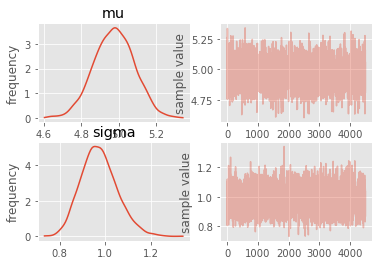

In [11]:
# 事後分布plot
# トレースプロットは横軸step縦軸サンプリングの値
# トレースプロットがまんべんなくplot（サンプリング）されているなら収束してる

fig = fit.plot()